In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve, gaussian_filter
from scipy.interpolate import interp2d
from random import sample

/var/folders/zs/kl_4mn7x77z1pzj6m2yc5f2w0000gn/T/ipykernel_74369/2782912191.py:4: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, gaussian_filter
/var/folders/zs/kl_4mn7x77z1pzj6m2yc5f2w0000gn/T/ipykernel_74369/2782912191.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, gaussian_filter


In [2]:
def myFlow(img1, img2, window_length, tau):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) / 255.0
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) / 255.0

    derivative_filter = np.array([-1, 8, 0, -8, 1]) / 12
    Ix = convolve(gray1, derivative_filter[np.newaxis])
    Iy = convolve(gray1, derivative_filter[np.newaxis].T)

    blurred1 = gaussian_filter(gray1, sigma=1)
    blurred2 = gaussian_filter(gray2, sigma=1)
    It = blurred2 - blurred1

    u = np.zeros_like(gray1)
    v = np.zeros_like(gray1)
    v_flow = np.zeros_like(gray1, dtype=bool)

    w = window_length // 2

    for y in range(w, gray1.shape[0] - w):
        for x in range(w, gray1.shape[1] - w):
            Ix_window = Ix[y - w:y + w + 1, x - w:x + w+ 1]
            Iy_window = Iy[y - w:y + w + 1, x - w:x + w + 1]
            It_window = It[y - w:y + w + 1, x - w:x + w + 1]

            A = np.vstack((Ix_window.flatten(), Iy_window.flatten())).T
            b = -It_window.flatten()

            if np.linalg.det(A.T @ A) < tau:
                continue

            uv = np.linalg.inv(A.T @ A) @ A.T @ b
            u[y, x], v[y, x] = uv
            v_flow[y, x] = True

    return u, v, v_flow

In [3]:
img1 = cv2.imread('sphere_0.png').astype(np.float32)
img2 = cv2.imread('sphere_1.png').astype(np.float32)

In [4]:
u,v, v_flow = myFlow(img1, img2, 13 , 0.000001)

In [5]:
def myWarp(img2, u, v):
    h, w = img2.shape[:2]
    num_channels = img2.shape[2] if img2.ndim == 3 else 1

    x, y = np.meshgrid(np.arange(w), np.arange(h))

    x_new = x + u
    y_new = y + v

    x_new = np.clip(x_new, 0, w - 1)
    y_new = np.clip(y_new, 0, h - 1)

    warped_img = np.zeros_like(img2)

    for ch in range(num_channels):
        if num_channels == 1:
            channel_img = img2
        else:
            channel_img = img2[:, :, ch]

        interpolator = interp2d(np.arange(w), np.arange(h), channel_img, kind='cubic')
        interpolated_img = interpolator(np.arange(w), np.arange(h))

        if num_channels == 1:
            warped_img = interpolated_img[y_new.astype(int), x_new.astype(int)]
        else:
            warped_img[:, :, ch] = interpolated_img[y_new.astype(int), x_new.astype(int)]

    return warped_img


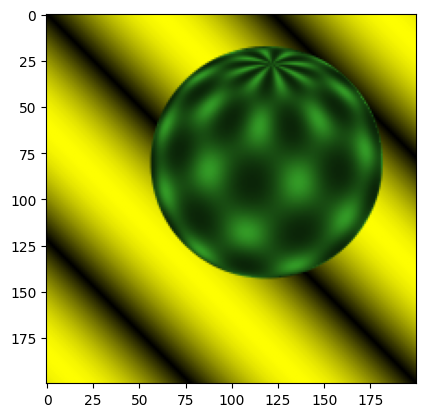

In [6]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

warped_img = myWarp(img2, u, v).astype(np.float32) / 255

#image 1 
plt.imshow(img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


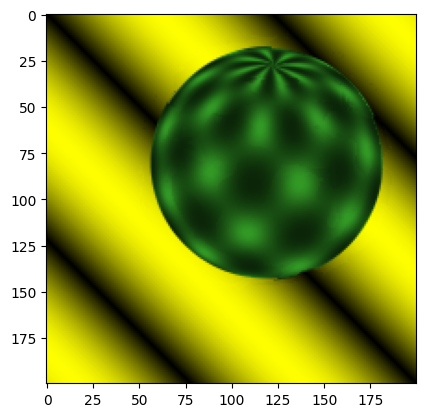

In [7]:
#warped image
plt.imshow(warped_img)